In [38]:
from scapy.all import * # Packet manipulation
import pandas as pd # Pandas - Create and Manipulate DataFrames
import numpy as np # Math Stuff (don't worry only used for one line :] )
import binascii # Binary to Ascii 
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
%matplotlib inline

Captura de 100 paquetes

In [39]:
num_of_packets_to_sniff = 100
pcap = sniff(count=num_of_packets_to_sniff)


In [40]:
analisis_paquetes = rdpcap("datasets/analisis_paquetes.pcap")


In [41]:
# add .pcap to sniffed packets
for pkt in analisis_paquetes:
    pcap.append(pkt)

TCP

In [42]:
"""
0                   1                   2                   3
0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
|          Source Port          |       Destination Port        |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
|                        Sequence Number                        |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
|                    Acknowledgment Number                      |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
|  Data |           |U|A|P|R|S|F|                               |
| Offset| Reserved  |R|C|S|S|Y|I|            Window             |
|       |           |G|K|H|T|N|N|                               |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
|           Checksum            |         Urgent Pointer        |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
|                    Options                    |    Padding    |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
|                             data                              |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
02 04 05 a0 01 03 03 05 01 01 08 0a 1d 74 65 c5 00 00 00 00 04 02 00 00
"""

print()

Exploración

In [43]:
#Recordemos que en los modelos de red, las capas inferiores encapsulan la información de las capas superiores
#Frames en paquetes, paquetes en segmentos (Ethernet, IP), modelo TCP/IP

ethernet_frame = pcap[0]
ip_packet = ethernet_frame.payload
segment = ip_packet.payload
data = segment.payload #recupera la informacion de la capa 4

print("Informacion del frame:")
print(ethernet_frame.summary())

print("Informacion del paquete:")
print(ip_packet.summary())

print("Informacion del segmento:")
print(segment.summary())

print("Data:")
print(data.summary())

ethernet_frame.show()
data.show()

Informacion del frame:
Ether / ARP who has 192.168.128.1 says 192.168.144.175
Informacion del paquete:
ARP who has 192.168.128.1 says 192.168.144.175
Informacion del segmento:

Data:

###[ Ethernet ]### 
  dst       = ff:ff:ff:ff:ff:ff
  src       = 78:4f:43:69:74:9c
  type      = ARP
###[ ARP ]### 
     hwtype    = 0x1
     ptype     = IPv4
     hwlen     = 6
     plen      = 4
     op        = who-has
     hwsrc     = 78:4f:43:69:74:9c
     psrc      = 192.168.144.175
     hwdst     = 00:00:00:00:00:00
     pdst      = 192.168.128.1



Tipos de datos en Scapy

In [44]:
print(type(ethernet_frame))
print(type(ip_packet))
print(type(segment))

# Packets can be filtered on layers ie) ethernet_frame[scapy.layers.l2.Ether]
ethernet_type = type(ethernet_frame)
ip_type = type(ip_packet)
tcp_type = type(segment)
print("Ethernet",pcap[ethernet_type])
print("IP", pcap[ip_type])
print("TCP", pcap[tcp_type])

# Scapy provides this via import statements
from scapy.layers.l2 import Ether
from scapy.layers.inet import IP
from scapy.layers.inet import TCP, UDP

print("UDP", pcap[UDP])

<class 'scapy.layers.l2.Ether'>
<class 'scapy.layers.l2.ARP'>
<class 'scapy.packet.NoPayload'>
Ethernet <Ether from Sniffed: TCP:84 UDP:76 ICMP:0 Other:2>
IP <ARP from Sniffed: TCP:0 UDP:0 ICMP:0 Other:2>
TCP <NoPayload from Sniffed: TCP:0 UDP:0 ICMP:0 Other:0>
UDP <UDP from Sniffed: TCP:0 UDP:76 ICMP:0 Other:0>


Conversion de PCAP a DF

In [45]:
# Obtenemos los campos de IP/TCP/UDP que seran las columnas de nuestro DF
ip_fields = [field.name for field in IP().fields_desc]
tcp_fields = [field.name for field in TCP().fields_desc]
udp_fields = [field.name for field in UDP().fields_desc]

#Concatenamos todos los campos
dataframe_fields = ip_fields + ['time'] + tcp_fields + ['payload','payload_raw','payload_hex']

# Creamos un DF en blanco con los campos como columnas
df = pd.DataFrame(columns=dataframe_fields)
for packet in pcap[IP]:
    # Obtenemos los valores de los campos de cada fila
    field_values = []
    # A;adimos todos los valores de los campos de IP al df
    for field in ip_fields:
        if field == 'options':
            # Obtenemos el numero de opciones del IP Header
            field_values.append(len(packet[IP].fields[field]))
        else:
            field_values.append(packet[IP].fields[field])
    
    field_values.append(packet.time)
    
    layer_type = type(packet[IP].payload)
    for field in tcp_fields:
        try:
            if field == 'options':
                field_values.append(len(packet[layer_type].fields[field]))
            else:
                field_values.append(packet[layer_type].fields[field])
        except:
            field_values.append(None)
    
    # Agregamos el payload
    field_values.append(len(packet[layer_type].payload))
    field_values.append(packet[layer_type].payload.original)
    field_values.append(binascii.hexlify(packet[layer_type].payload.original))
    # Agregamos la fila al df
    df_append = pd.DataFrame([field_values], columns=dataframe_fields)
    df = pd.concat([df, df_append], axis=0)

# Reset Index
df = df.reset_index()
# Drop old index column
df = df.drop(columns="index")

print(df.columns)
df.head(5)

Index(['version', 'ihl', 'tos', 'len', 'id', 'flags', 'frag', 'ttl', 'proto',
       'chksum', 'src', 'dst', 'options', 'time', 'sport', 'dport', 'seq',
       'ack', 'dataofs', 'reserved', 'flags', 'window', 'chksum', 'urgptr',
       'options', 'payload', 'payload_raw', 'payload_hex'],
      dtype='object')


,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,...,dataofs,reserved,flags,window,chksum,urgptr,options,payload,payload_raw,payload_hex
0,4,5,0,40,649,,0,64,6,8988,...,5,0,A,2048,62100,0,None,0,b'',b''
1,4,5,72,52,44670,,0,123,6,15314,...,8,0,A,326,56220,0,3,0,b'',b''
2,4,5,0,91,632,,0,64,17,23890,...,None,None,None,None,52714,None,None,63,b'\xef\xea\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'efea01000001000000000000106f6e656473636f6c70...
3,4,5,0,107,5246,,0,127,17,3132,...,None,None,None,None,15047,None,None,79,b'\xef\xea\x81\x80\x00\x01\x00\x01\x00\x00\x00...,b'efea81800001000100000000106f6e656473636f6c70...
4,4,5,0,64,0,DF,0,64,6,10091,...,11,0,SEC,65535,62377,0,8,0,b'',b''


In [46]:
# Return Src Address, Dst Address, Src Port, Dst Port
df[['src','dst','sport','dport']]

,src,dst,sport,dport
0,192.168.144.175,35.186.224.25,49923,443
1,35.186.224.25,192.168.144.175,443,49923
2,192.168.144.175,192.168.8.200,50647,53
3,192.168.8.200,192.168.144.175,53,50647
4,192.168.144.175,52.182.141.63,49941,443
...,...,...,...,...
154,84.54.22.33,10.1.10.53,53,53
155,10.1.10.53,84.54.22.33,53,53
156,84.54.22.33,10.1.10.53,53,53
157,10.1.10.53,84.54.22.33,53,53


Muestre cual es la IP origen que más aparece

In [47]:
#Calcular estadisticas
print("# Top Source Address")
print(df['src'].describe(),'\n\n')

# Top Source Address
count                 159
unique                 17
top       192.168.144.175
freq                   50
Name: src, dtype: object 




Muestre cual es la IP destino que más aparece

In [49]:
print("# Top Destination Address")
print(df['dst'].describe(),'\n\n')

# Top Destination Address
count                 159
unique                 20
top       192.168.144.175
freq                   43
Name: dst, dtype: object 




In [67]:
print("¿Quien es la IP de origen mas frecuente?")
frequent_address = df['src'].describe()['top']
print(frequent_address, '\n')


print("A que IPs les habla la IP mas frecuente:")
print(df[df['src'] == frequent_address]['dst'].value_counts())

¿Quien es la IP de origen mas frecuente?
192.168.144.175 

A que IPs les habla la IP mas frecuente:
52.182.141.63      13
172.217.15.202     12
239.255.255.250     5
142.250.217.163     4
35.186.224.25       3
146.75.34.248       2
35.186.224.42       2
35.186.224.47       2
192.168.8.200       1
172.217.165.195     1
104.154.127.126     1
34.98.74.57         1
151.101.6.248       1
224.0.0.251         1
192.168.191.255     1
Name: dst, dtype: int64


In [63]:
print("A que puertos destino les habla la IP mas frecuente:")
print(df[df['src'] == frequent_address]['dport'].value_counts())

A que puertos destino les habla la IP mas frecuente:
443      41
1900      5
53        1
4070      1
5353      1
57621     1
Name: dport, dtype: int64


In [64]:

print("A que puertos de origen les habla la IP mas frecuente:")
print(df[df['src'] == frequent_address]['sport'].value_counts())

A que puertos de origen les habla la IP mas frecuente:
49941    13
60989     7
60988     5
55910     4
60970     4
49919     2
49922     2
49923     1
49928     1
57621     1
5353      1
49917     1
49927     1
49934     1
50647     1
49913     1
49916     1
49929     1
49918     1
64214     1
Name: sport, dtype: int64


¿Para que se utiliza el puerto que más aparece en el inciso d y e?
<br> <br>
El puerto 433 (puerto destino más frecuente) es utilizado para servicios HTTPS. El puerto 49941 es un puerto dinámico/privado.

## Gráficas

a. Muestre una gráfica 2D, en el eje Y las IPs origen, y en el eje X la suma de los payloads
enviados de dichas direcciones. <br>
b. Muestre una gráfica 2D, en el eje Y las IPs destino, y en el eje X la suma de los payloads
recibidos en dichas direcciones. <br>
c. Muestre una gráfica 2D, en el eje Y los puertos origen, y en el eje X la suma de los
payloads enviados de dichos puertos.<br>
d.
Muestre una gráfica 2D, en el eje Y los puertos destino, y en el eje X la suma de los payloads recibidos en dichos puertos. <br>

<AxesSubplot:xlabel='payload', ylabel='src'>

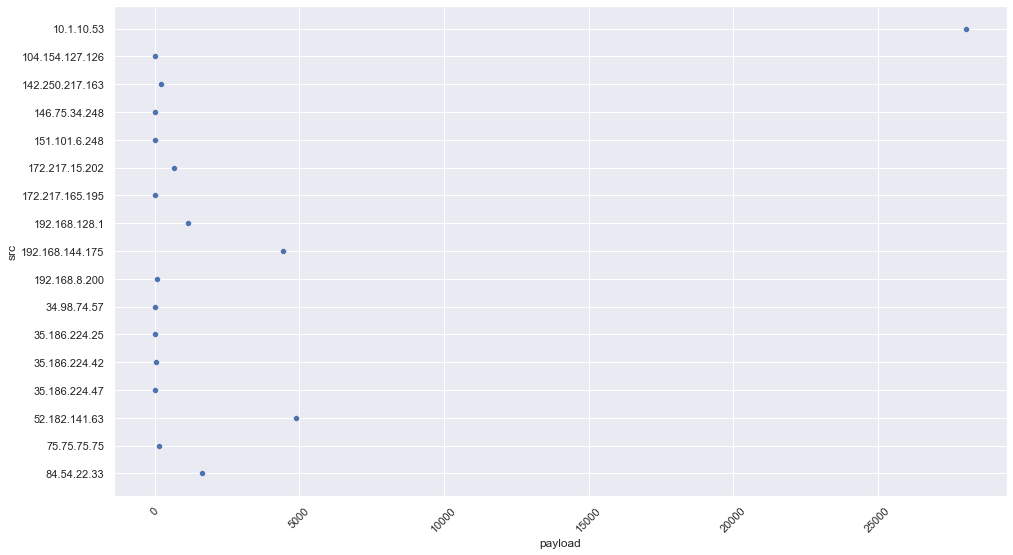

In [97]:
plt.figure(figsize=(16,9))
plt.xticks(rotation=45)

data = df.groupby(['src'])['payload'].sum()
sns.scatterplot(x=data, y=data.index)

<AxesSubplot:xlabel='payload', ylabel='dst'>

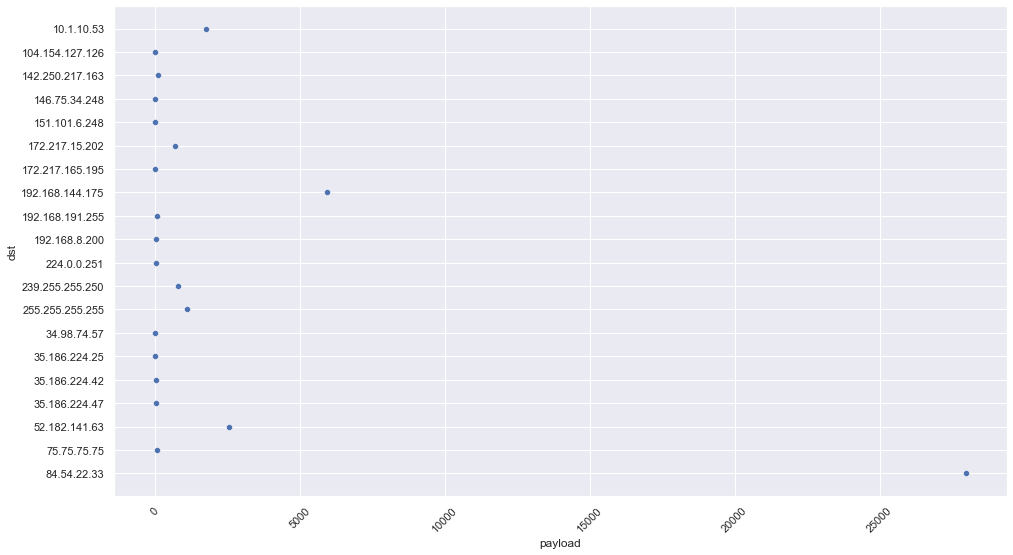

In [101]:
plt.figure(figsize=(16,9))
plt.xticks(rotation=45)

data = df.groupby(['dst'])['payload'].sum()
sns.scatterplot(x=data, y=data.index)

<AxesSubplot:xlabel='payload', ylabel='sport'>

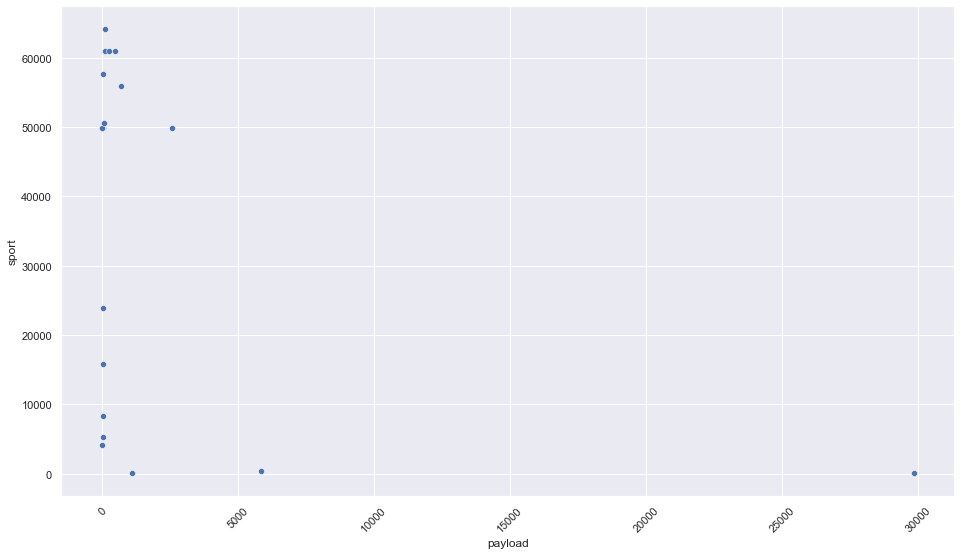

In [102]:
plt.figure(figsize=(16,9))
plt.xticks(rotation=45)

data = df.groupby(['sport'])['payload'].sum()
sns.scatterplot(x=data, y=data.index)

<AxesSubplot:xlabel='payload', ylabel='dport'>

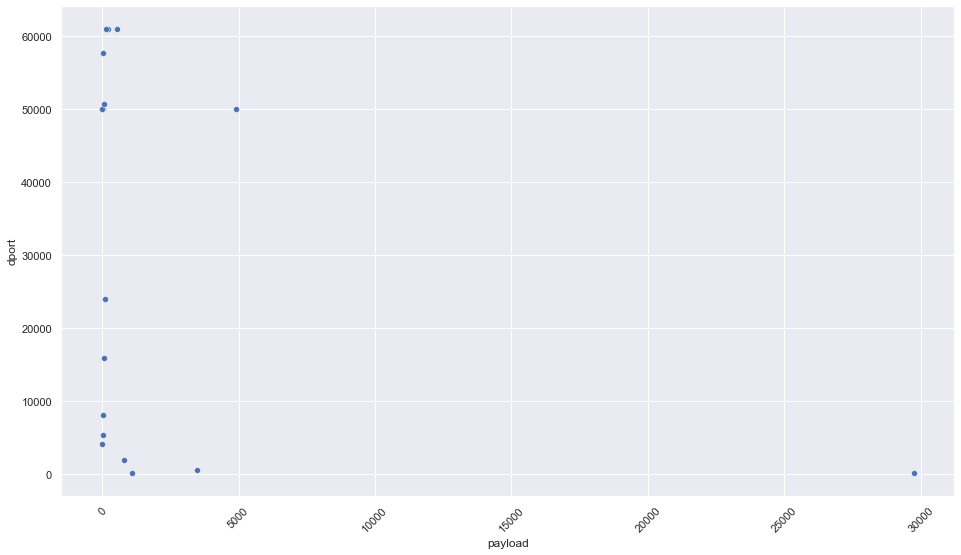

In [103]:
plt.figure(figsize=(16,9))
plt.xticks(rotation=45)

data = df.groupby(['dport'])['payload'].sum()
sns.scatterplot(x=data, y=data.index)

## Payload

a. Cree un nuevo DF que incluya únicamente la conversación de la dirección IP origen más frecuente <br>
b. Obtenga un nuevo DF con las columnas Src Address, Dst Address y agrúpelas por payload <br>
c. Obtenga la IP que más ha intercambiado bytes con la IP más frecuente. Esta IP es sospechosa por la cantidad de bytes intercambiados, entre todas las direcciones. <br>
d. Cree un nuevo DF con la conversación entre la IP más frecuenta y la IP sospechosa. <br>
e. Obtenga los payloads del DF del inciso 6, y añada cada uno en un array. <br>
f. Muestre el contenido del array. <br>
g. Examine los primeros bytes del contenido, ¿encuentra algún dato que no haga sentido
que se envie a través del puerto explicado en el inciso f? <br>